**MACHINE LEARNING**

**HRV for detecting arousal**

In [1]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut, KFold, GridSearchCV
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression


In [2]:
# Loading the dataset
file = r"C:\Users\Salin\OneDrive\Documentos\ESSEX\DSPROJECT\PPG_HR_Analysis_Longer_Intervals_\PPG\merged_features_norm_grey_arousal.csv"
df = pd.read_csv(file)

# Displaying info
df.head()
len(df)

1633

In [3]:
X = df.drop(columns=['Participant', 'Stimulus', 'Arousal'])
y = df['Arousal']
groups = df['Participant']

In [4]:
def evaluate_regression(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predicted_values)
    r2 = r2_score(true_values, predicted_values)

    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R² Score: {r2:.3f}")
    return

**XGBOOST REGRESSOR**

In [6]:
logo = LeaveOneGroupOut()

In [7]:
true_values = []
predicted_values = []

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)

print("LOPO without hyperparameter tuning:")
evaluate_regression(true_values, predicted_values)


LOPO without hyperparameter tuning:
RMSE: 0.262
MAE: 0.207
R² Score: 0.150


In [8]:
global_corr = X.corrwith(y)
global_corr = global_corr.sort_values(key=abs, ascending=False)
global_corr.head(10)

F1_CrossingPoints   -0.303023
pVLF                -0.177234
aVLF                -0.114722
pLF                  0.082139
F3_MaxArea          -0.063974
nLF                  0.061546
aTotal              -0.048857
aLF                 -0.041238
NN50                -0.037958
nHF                 -0.037519
dtype: float64

In [9]:
# Checking number of missing values per column
missing_counts = X.isna().sum()

# Displaying only columns that have missing values
missing_counts[missing_counts > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [10]:
X_mi = X.copy()

# Filling NaNs with column means 
X_mi = X_mi.fillna(X_mi.mean())

<Axes: title={'center': 'Mutual Information Scores'}>

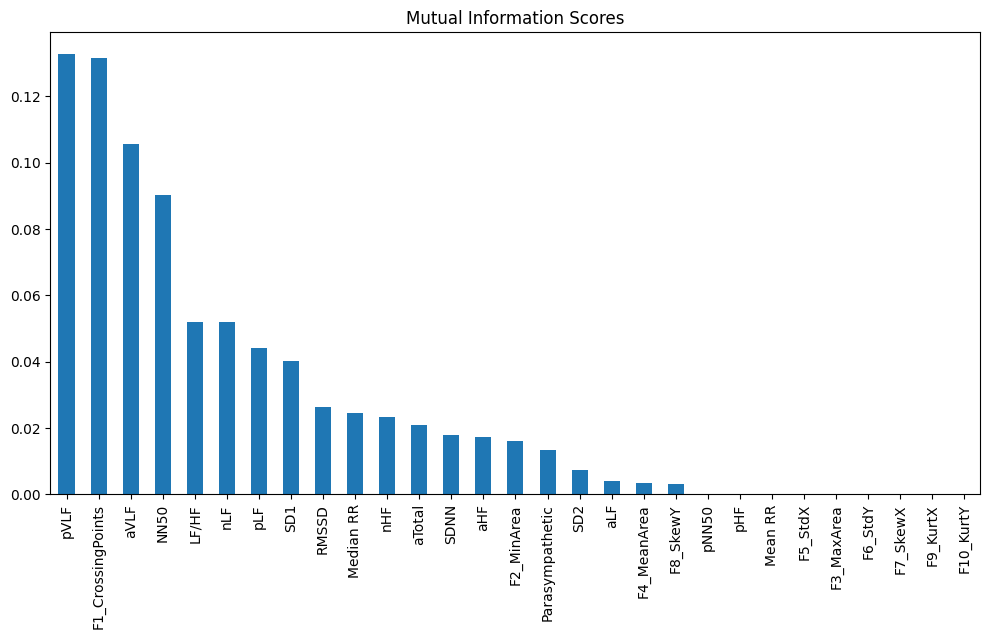

In [12]:
# MI between each feature and arousal
mi_scores = mutual_info_regression(X_mi, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns)
mi_series.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title='Mutual Information Scores')

In [13]:
mi_series.sort_values(ascending=False).head(20)

pVLF                 0.132705
F1_CrossingPoints    0.131562
aVLF                 0.105784
NN50                 0.090358
LF/HF                0.052012
nLF                  0.051892
pLF                  0.044264
SD1                  0.040185
RMSSD                0.026439
Median RR            0.024663
nHF                  0.023207
aTotal               0.020876
SDNN                 0.017736
aHF                  0.017421
F2_MinArea           0.015967
Parasympathetic      0.013433
SD2                  0.007306
aLF                  0.003962
F4_MeanArea          0.003276
F8_SkewY             0.003162
dtype: float64

In [29]:
selected_features = selected_features = mi_series[mi_series > 0.02].index.tolist()
X = df[selected_features]
X.head()

,Median RR,RMSSD,NN50,aVLF,aTotal,pVLF,pLF,LF/HF,nLF,nHF,SD1,F1_CrossingPoints
0,0.051768,0.352012,-0.471698,-1.000000,0.949087,-1.000000,-0.616404,-0.659274,-0.617551,0.122455,0.228346,-0.538462
1,0.283778,0.700875,-0.528302,-1.000000,0.463529,-1.000000,-0.237624,-0.274420,-0.239903,0.047571,0.472053,-0.532967
2,-0.016555,0.587072,-0.811321,-1.000000,1.874433,-1.000000,-1.000000,-1.000000,-1.000000,0.198291,0.258725,-0.802198
3,-0.064676,0.246371,-0.169811,8.750069,-0.413262,15.617413,0.187468,0.309652,0.245816,-0.048743,0.068703,-0.049451
4,0.063702,0.242915,-0.547170,-1.000000,0.515692,-1.000000,-0.387740,-0.433344,-0.389570,0.077248,0.222139,-0.560440


In [30]:
filtered_df = df.dropna(subset=selected_features + ['Arousal'])  # Keeping only valid raws
print(f"Total raws after deleting the Nans:", len(filtered_df))

Total raws after deleting the Nans: 1633


In [31]:
X = filtered_df[selected_features]
y = filtered_df['Arousal']
groups = filtered_df['Participant']

In [32]:
true_values = []
predicted_values = []

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)

print("LOPO without hyperparameter tuning with most significant features:")
evaluate_regression(true_values, predicted_values)

LOPO without hyperparameter tuning with most significant features:
RMSE: 0.265
MAE: 0.207
R² Score: 0.133


In [33]:
true_values = []
predicted_values = []
results = [] 
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    test_participant = groups.iloc[test_idx].unique()[0]

    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(XGBRegressor(random_state=42), param_grid,
                        cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)

    rmse = root_mean_squared_error(y_test, y_pred)

    # Saving Parameters 
    results.append({
        'Participant': test_participant,
        'RMSE': rmse,
        **grid.best_params_
    })

print("Nested LOPO with hyperparameter tuning:")
evaluate_regression(true_values, predicted_values)

# For further use if necessary to check the best parameters
results_df = pd.DataFrame(results)
params_df = results_df.drop(columns=['Participant', 'RMSE'])

Nested LOPO with hyperparameter tuning:
RMSE: 0.242
MAE: 0.196
R² Score: 0.276


Best Parameters per Participant

To understand whether certain model configurations generalize better, the best hyperparameters selected during each LOPO iteration were tracked.

Below:
- The most commonly selected configuration.
- The configuration that resulted in the lowest average RMSE across participants.


In [34]:
# The most used configuration
most_common_configs = (
    params_df.value_counts()
    .reset_index(name='Count')
    .sort_values(by='Count', ascending=False)
    .head(3)
)
print("Most Common Configurations:")
display(most_common_configs)

# The best config for better results
best_avg_configs = (
    results_df
    .groupby(['n_estimators', 'max_depth', 'learning_rate', 'subsample'])['RMSE']
    .mean()
    .reset_index()
    .sort_values(by='RMSE')
    .head(3)
)
print("Best Performing Configurations (Lowest Avg. RMSE):")
display(best_avg_configs)


Most Common Configurations:


,learning_rate,max_depth,n_estimators,subsample,Count
0,0.01,5,200,0.8,20
1,0.01,3,200,0.8,17
2,0.01,5,200,1.0,4


Best Performing Configurations (Lowest Avg. RMSE):


,n_estimators,max_depth,learning_rate,subsample,RMSE
3,200,5,0.01,1.0,0.212268
2,200,5,0.01,0.8,0.236323
0,200,3,0.01,0.8,0.239147


**Random Forest Regressor**

In [35]:
true_values = []
predicted_values = []

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)

evaluate_regression(true_values, predicted_values)
    

RMSE: 0.246
MAE: 0.195
R² Score: 0.252


In [36]:
true_values = []
predicted_values = []
best_params_list = []

# Hyperparameters tunning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

    grid = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_grid=param_grid,
        cv=inner_cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)
    best_params_list.append(grid.best_params_)

evaluate_regression(true_values, predicted_values)

RMSE: 0.243
MAE: 0.191
R² Score: 0.272


In [37]:
best_params_df = pd.DataFrame(best_params_list)
print("\nBest hyperparameters per participant:")
display(best_params_df.value_counts().head())


Best hyperparameters per participant:


max_depth  min_samples_leaf  min_samples_split  n_estimators
10         1                 2                  200             13
                             5                  200             11
           2                 5                  200              5
           1                 2                  100              4
                             5                  100              3
Name: count, dtype: int64